# Pendulum system identification

In [47]:
import numpy as np
import scipy
from scipy import linalg
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from tqdm import tqdm

## Generate data

$$\begin{align*}
\frac{dx_1}{dt} &= x_2\\
\frac{d x_2}{dt} &= - \frac{g}{L}\sin(x_1) - c\ x_2\\
\end{align*}$$

$$\begin{align*}
x_{1,k+1} &= x_{1,k} + (x_{2,k})* dt + \xi_{1,k+1}  & x_{1,0} = \frac{\pi}{8}\\
x_{2,k+1} &= x_{2,k}+ \left(- \frac{g}{L}\sin(x_{1,k}) - c\ x_{2,k}\right) * dt + \xi_{2,k+1} & x_{2,0} = \frac{3\pi}{2}\\
\xi_{i,j} &\overset{\text{ind.}}{\sim} \textsf{Normal}(0,\sigma^2)\ g = 9.81, \ L = 1.0, \ c = 0.03, \ dt = 0.25\\
\end{align*}$$

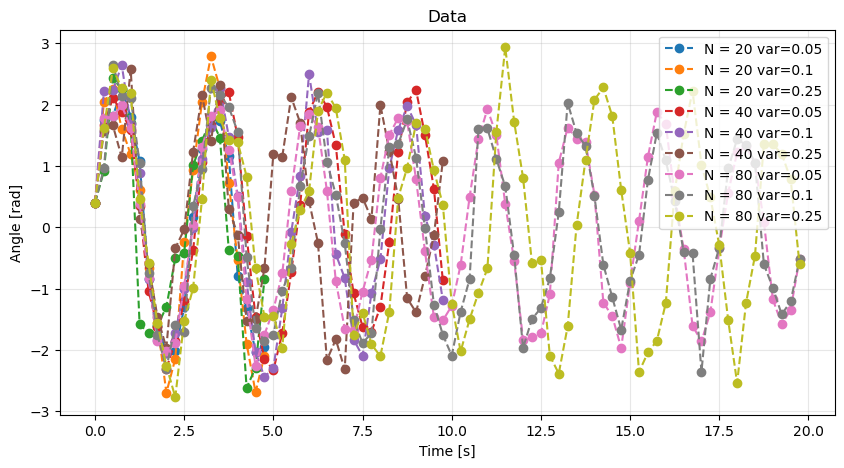

In [40]:
def pendulum_rhs_noise(Nt, x_0, var):
    dt = 0.25
    g = 9.81
    L = 1.0
    c = 0.03
    x1, x2 = x_0
    sol = np.zeros((int(Nt/dt)))
    sol[0] = x1
    for time in range(1, int(Nt/dt)):
        x1 = x1 + (x2  + np.random.randn() * var) * dt
        x2 = x2 + (-(g/L) * np.sin(x1) - c * x2 + np.random.randn() * np.sqrt(var)) * dt 
        y = x1 + np.random.randn() * np.sqrt(var)
        sol[time] = y
    return np.arange(0, Nt, dt), sol

x_0 = np.array([np.pi/8, 3*np.pi/2])

datasets = {}
for N in [20,40,80]:
    datasets[f"N = {N}"] = {}
    for var in [0.050, 0.100, 0.250]:
        t_eval, sol = pendulum_rhs_noise(N*0.25, x_0, var)
        datasets[f"N = {N}"][f"var={var}"] = {
            "t": t_eval,
            "y": sol 
        }

plt.figure(figsize=(10, 5))
for label, data in datasets.items():
    for var_label, data in data.items():
        plt.plot(data["t"], data["y"], 'o--', label=f'{label}'+ f' {var_label}')
plt.xlabel('Time [s]')
plt.ylabel('Angle [rad]')
plt.title('Data')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [43]:
save_dict = {}
for N_label, inner_dict in datasets.items():
    for var_label, data in inner_dict.items():
        key_base = f"{N_label}_{var_label}".replace(" ", "").replace("=", "")
        save_dict[f"t_{key_base}"] = data["t"]
        save_dict[f"y_{key_base}"] = data["y"]

np.savez("pendulum_datasets.npz", **save_dict)
print("✅ Datos guardados en 'pendulum_datasets.npz'")

✅ Datos guardados en 'pendulum_datasets.npz'


In [42]:
datasets

{'N = 20': {'var=0.05': {'t': array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
          2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75]),
   'y': array([ 0.39269908,  1.75596471,  1.80756846,  2.24987098,  1.80058482,
           1.07260666, -0.84604096, -1.60530128, -2.04527931, -2.01717623,
          -1.30813986,  0.16178521,  1.27670115,  1.63456166,  1.73653485,
           1.1585829 , -0.7907974 , -1.31511013, -2.03730063, -1.94699215])},
  'var=0.1': {'t': array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  , 2.25, 2.5 ,
          2.75, 3.  , 3.25, 3.5 , 3.75, 4.  , 4.25, 4.5 , 4.75]),
   'y': array([ 0.39269908,  2.04540299,  2.24655512,  1.60844104,  1.18804489,
           0.60739309, -0.67241233, -1.56797909, -2.70073899, -2.14559494,
          -0.24199043,  0.93249261,  2.04217329,  2.78570073,  2.26876504,
           0.71478091, -0.53737232, -1.89925002, -2.69255797, -2.09600162])},
  'var=0.25': {'t': array([0.  , 0.25, 0.5 , 0.75, 1.  , 

In [24]:
def _log_gaussian_density(y, mu, S):
    d = len(y)
    diff = y - mu
    try:
        c, lower = linalg.cho_factor(S, check_finite=False)
        alpha = linalg.cho_solve((c, lower), diff)
        logdet = 2 * np.sum(np.log(np.diag(c)))
    except np.linalg.LinAlgError:
        alpha = np.linalg.solve(S, diff)
        logdet = np.log(np.linalg.det(S))
    return -0.5 * (diff.T @ alpha + logdet + d * np.log(2 * np.pi))

def lossSINDy(theta, t_data, y_data, f, x0):
    sol = solve_ivp(lambda t, x: f(t, x, theta),
                    (t_data[0], t_data[-1]),
                    x0,
                    t_eval=t_data,
                    method='RK45')
    x_model = sol.y.T  # (n, d)
    residuals = y_data - x_model
    return np.sum(residuals**2)


def lossDMD(theta, y_data, f):
    residuals = np.array([y_data[i] - f(y_data[i-1], theta) for i in range(1, len(y_data))])
    return np.sum(residuals**2)

def linearkalman(theta, Y, m0, P0, prior_logpdf, A_fn, H_fn, Sigma_fn, Gamma_fn):
    Y = np.asarray(Y)
    n, m = Y.shape

    log_prior = prior_logpdf(theta)
    logL = 0.0

    mk = m0.copy()
    Pk = P0.copy()

    for k in range(n):
        # Predict
        A = np.atleast_2d(A_fn(theta))
        Sigma = np.atleast_2d(Sigma_fn(theta))
        m_minus = A @ mk
        P_minus = A @ Pk @ A.T + Sigma

        # Evidence
        H = np.atleast_2d(H_fn(theta))
        Gamma = np.atleast_2d(Gamma_fn(theta))
        mu_k = H @ m_minus
        S_k = H @ P_minus @ H.T + Gamma

        yk = Y[k]
        logp = _log_gaussian_density(yk, mu_k, S_k)
        logL += logp

        # Update
        try:
            c, lower = linalg.cho_factor(S_k, check_finite=False)
            S_inv_HT = linalg.cho_solve((c, lower), H.T, check_finite=False)
        except np.linalg.LinAlgError:
            S_inv_HT = np.linalg.inv(S_k) @ H.T

        K = P_minus @ S_inv_HT
        innovation = yk - mu_k
        mk = m_minus + K @ innovation
        Pk = P_minus - K @ H @ P_minus
        Pk = (Pk + Pk.T) / 2.0
        Pk += 1e-8 * np.eye(Pk.shape[0])

    log_post = log_prior + logL
    return {
        'log_prior': log_prior,
        'log_likelihood': logL,
        'log_posterior': log_post,
        'prediction': (mk, Pk)
    }


def unscentedkalman(theta, Y, m0, P0, prior_logpdf,
                          Phi, h, Sigma_fn, Gamma_fn,
                          alpha=1e-3, beta=2.0, kappa=0.0):
    Y = np.asarray(Y)
    n, m = Y.shape
    d = m0.shape[0]
    log_prior = prior_logpdf(theta)

    mk = m0.astype(np.float64).copy()
    Pk = P0.astype(np.float64).copy()
    logL = 0.0

    lambd = alpha**2 * (d + kappa) - d
    denom = d + lambd
    w0m = lambd / denom
    w0c = w0m + (1 - alpha**2 + beta)
    wim = 1.0 / (2.0 * denom)
    sqrt_d_lamb = np.sqrt(denom)

    for k in range(n):
        # Predict
        try:
            A = np.linalg.cholesky(Pk)
        except np.linalg.LinAlgError:
            A = np.linalg.cholesky(Pk + 1e-8 * np.eye(d))

        x_points = np.empty((d, 2*d + 1))
        x_points[:, 0] = mk
        for i in range(d):
            col = A[:, i]
            x_points[:, 1 + i] = mk + sqrt_d_lamb * col
            x_points[:, 1 + d + i] = mk - sqrt_d_lamb * col

        x_hat_points = np.empty_like(x_points)
        for i in range(2*d + 1):
            x_hat_points[:, i] = Phi(x_points[:, i], theta)

        m_minus = w0m * x_hat_points[:, 0] + wim * np.sum(x_hat_points[:, 1:], axis=1)
        P_minus = np.atleast_2d(Sigma_fn(theta)).astype(np.float64)
        for i in range(2*d + 1):
            diff = x_hat_points[:, i] - m_minus
            if i == 0:
                P_minus += w0c * np.outer(diff, diff)
            else:
                P_minus += wim * np.outer(diff, diff)
        P_minus = (P_minus + P_minus.T) / 2.0

        # Measurement
        try:
            A2 = np.linalg.cholesky(P_minus)
        except np.linalg.LinAlgError:
            A2 = np.linalg.cholesky(P_minus + 1e-8 * np.eye(d))

        x_points2 = np.empty((d, 2*d + 1))
        x_points2[:, 0] = m_minus
        for i in range(d):
            col = A2[:, i]
            x_points2[:, 1 + i] = m_minus + sqrt_d_lamb * col
            x_points2[:, 1 + d + i] = m_minus - sqrt_d_lamb * col

        y_hat_points = np.empty((m, 2*d + 1))
        for i in range(2*d + 1):
            y_hat_points[:, i] = h(x_points2[:, i], theta)

        mu_k = w0m * y_hat_points[:, 0] + wim * np.sum(y_hat_points[:, 1:], axis=1)
        S_k = np.atleast_2d(Gamma_fn(theta)).astype(np.float64)
        for i in range(2*d + 1):
            diffy = y_hat_points[:, i] - mu_k
            if i == 0:
                S_k += w0c * np.outer(diffy, diffy)
            else:
                S_k += wim * np.outer(diffy, diffy)
        S_k = (S_k + S_k.T) / 2.0

        yk = Y[k]
        logL += _log_gaussian_density(yk, mu_k, S_k)

        # Update
        C_k = np.zeros((d, m))
        for i in range(2*d + 1):
            dx = x_points2[:, i] - m_minus
            dy = y_hat_points[:, i] - mu_k
            if i == 0:
                C_k += w0c * np.outer(dx, dy)
            else:
                C_k += wim * np.outer(dx, dy)

        try:
            cho = np.linalg.cholesky(S_k)
            K = np.linalg.cho_solve((cho, True), C_k.T).T
        except Exception:
            S_inv = np.linalg.inv(S_k)
            K = C_k @ S_inv

        mk = m_minus + K @ (yk - mu_k)
        Pk = P_minus - K @ C_k.T
        Pk = (Pk + Pk.T) / 2.0

    return {
        'log_prior': log_prior,
        'log_likelihood': logL,
        'log_posterior': log_prior + logL,
        'prediction': (mk, Pk)
    }


In [ ]:

def dt_pendulum_rhs(t, x, theta):
    x1, x2 = x
    dx1_dt = theta[0] * x2
    dx2_dt = theta[1] * x1
    return [dx1_dt, dx2_dt]

def discrete_pendulum(y, theta):
    Phi = 0.5 * np.array([[0, theta[0]], [theta[1], 0]])
    return scipy.linalg.expm(Phi) @ y

def prior_logpdf(theta):
    return -0.5 * ((theta[0])**2 / 1.0**2 + (theta[1])**2 / 1.0**2)

def A(theta):
    Phi = 0.5 * np.array([[0, theta[0]], [theta[1], 0]])
    return scipy.linalg.expm(Phi)

def H(theta): return np.eye(2)
def Sigma(theta): return 0.01 * np.eye(2)
def Gamma(theta): return 0.5 * np.eye(2)

m0 = np.array(x_0)
P0 = 0.5**2 * np.eye(2)
true_theta = (1.0, -9.81)
sigma_fixed = 0.1
theta1_vals = np.linspace(0.05, 5.0, 40)
theta2_vals = np.linspace(-30.0, -0.5, 40)
X, Y = np.meshgrid(theta1_vals, theta2_vals)

datasets_to_plot = ['N = 20', 'N = 40', 'N = 80']
loss_functions = ['lossSINDy', 'lossDMD', 'linearkalman']
sigma_fixed = 0.1
cmap = 'viridis'


loss_grids = {}  

for ds_name in datasets_to_plot:
    data = datasets[ds_name][f'sigma={sigma_fixed}']
    t = data['t']
    y = data['y']

    for loss_type in loss_functions:
        loss_grid = np.zeros((len(theta1_vals), len(theta2_vals)))
        for i, th1 in enumerate(theta1_vals):
            for j, th2 in enumerate(theta2_vals):
                theta = np.array([th1, th2])
                if loss_type == 'lossSINDy':
                    val = lossSINDy(theta, t, y, dt_pendulum_rhs, x_0)
                elif loss_type == 'lossDMD':
                    val = lossDMD(theta, y, discrete_pendulum)
                elif loss_type == 'linearkalman':
                    res = linearkalman(theta, y, m0, P0, prior_logpdf, A, H, Sigma, Gamma)
                    val = -res['log_posterior']
                loss_grid[i, j] = val
        loss_grids[(ds_name, loss_type)] = loss_grid

# ----------------------------
# 2. Escalado global min–max
# ----------------------------
#all_vals = np.concatenate([g.ravel() for g in loss_grids.values()])
#global_min, global_max = np.nanmin(all_vals), np.nanmax(all_vals)

#for key in loss_grids:
#    g = loss_grids[key]
#    g_scaled = (g - global_min) / (global_max - global_min)
#    loss_grids[key] = g_scaled

# ----------------------------
# 3. Graficado
# ----------------------------
fig, axes = plt.subplots(3, 3, figsize=(14, 12), sharex=True, sharey=True)
plt.subplots_adjust(wspace=0.2, hspace=0.25, right=0.88)

for row_idx, ds_name in enumerate(datasets_to_plot):
    for col_idx, loss_type in enumerate(loss_functions):
        g = loss_grids[(ds_name, loss_type)]
        cont = axes[row_idx, col_idx].contourf(
            X, Y, g.T, levels=20, cmap=cmap,
        )
        axes[row_idx, col_idx].contour(
            X, Y, g.T, levels=20, colors='k', linewidths=0.5
        )
        axes[row_idx, col_idx].plot(true_theta[0], true_theta[1], 'r*', markersize=10)

        if row_idx == 2:
            axes[row_idx, col_idx].set_xlabel(r'$\theta_1$')
        if col_idx == 0:
            axes[row_idx, col_idx].set_ylabel(r'$\theta_2$')

        if row_idx == 0:
            if loss_type == 'lossSINDy':
                title = r"$\Sigma= 0$"
            elif loss_type == 'lossDMD':
                title = r"$\Gamma = 0$"
            elif loss_type == 'linearkalman':
                title = "Noise mixture"
            axes[row_idx, col_idx].set_title(title, fontsize=13)

# Colorbar común
cbar_ax = fig.add_axes([0.9, 0.15, 0.02, 0.7])
cbar = fig.colorbar(cont, cax=cbar_ax, label='Loss')

# Etiquetas de filas
for i, ds_name in enumerate(datasets_to_plot):
    axes[i, 0].text(-0.25, 0.5, ds_name,
                    transform=axes[i, 0].transAxes,
                    rotation=90, va='center', ha='right',
                    fontsize=12, fontweight='bold')

plt.show()


## DMD system identification

$$\begin{equation*}
        X = \begin{bmatrix}
            | & | & & | \\
            x_1 & x_2 & \cdots & x_{N-1}\\
            | & | & & | \\ \end{bmatrix} \quad  X' = \begin{bmatrix}
            | & | & & | \\
            x_2 & x_3 & \cdots & x_{N}\\
            | & | & & | \\
        \end{bmatrix}
    \end{equation*}$$

$$\begin{equation*}
        A = \underset{A\in \mathbb{R}^{2\times 2}}{\text{argmin}}\|X' - AX\|_{F} = X'X^{\dagger}
    \end{equation*}$$


## SINDy system identification

## Bayesian system identification



$$ \begin{bmatrix}x_{1,k+1} \\ x_{2,k+1}\end{bmatrix} =  \begin{bmatrix}\theta_1 & \theta_2 \\ \theta_3 & \theta_4\end{bmatrix}\begin{bmatrix}x_{1,k} \\ x_{2,k}\end{bmatrix} + \begin{bmatrix}\xi_{1,k+1} \\ \xi_{2,k+1}\end{bmatrix}, \quad \begin{bmatrix}\xi_{1,k+1} \\ \xi_{2,k+1}\end{bmatrix} \sim \textsf{Normal}\left(\begin{bmatrix}0 \\ 0\end{bmatrix},\begin{bmatrix}\exp(\theta_5) & 0 \\ 0 & \exp(\theta_6)\end{bmatrix}\right)$$
$$y_{k+1} = \begin{bmatrix}1 & 0\end{bmatrix}\begin{bmatrix}x_{1,k+1} \\ x_{2,k+1}\end{bmatrix} + \eta_{k+1}, \quad \eta_{k+1} \sim \textsf{Normal}(0,\exp(\theta_7)) \quad \text{for } k=0,1, \ldots, N-1$$




In [ ]:
def linearkalman(theta, Y, m0, P0, prior_logpdf, A_fn, H_fn, Sigma_fn, Gamma_fn):
    Y = np.asarray(Y)
    if Y.ndim == 1:
        Y = Y[:, None]
    n, m = Y.shape

    log_prior = prior_logpdf(theta)
    logL = 0.0

    mk = m0.copy()
    Pk = P0.copy()

    for k in range(n):
        # Predict
        A = np.atleast_2d(A_fn(theta))
        Sigma = np.atleast_2d(Sigma_fn(theta))
        m_minus = A @ mk
        P_minus = A @ Pk @ A.T + Sigma

        # Evidence
        H = np.atleast_2d(H_fn(theta))
        Gamma = np.atleast_2d(Gamma_fn(theta))
        mu_k = H @ m_minus
        S_k = H @ P_minus @ H.T + Gamma

        yk = Y[k]
        logp = _log_gaussian_density(yk, mu_k, S_k)
        logL += logp

        # Update
        try:
            c, lower = linalg.cho_factor(S_k, check_finite=False)
            S_inv = linalg.cho_solve((c, lower), np.eye(S_k.shape[0]), check_finite=False)
        except np.linalg.LinAlgError:
            S_inv = np.linalg.inv(S_k)

        K = P_minus @ H.T @ S_inv
        innovation = yk - mu_k
        mk = m_minus + K @ innovation
        Pk = P_minus - K @ H @ P_minus
        Pk = (Pk + Pk.T) / 2.0
        Pk += 1e-8 * np.eye(Pk.shape[0])

    log_post = log_prior + logL
    return {
        'log_prior': log_prior,
        'log_likelihood': logL,
        'log_posterior': log_post,
        'prediction': (mk, Pk)
    }


def bayeslinearpendulum(params):
    # Initialzation
    t , y = params['t'], params['y']
    dt = t[1] - t[0]
    N = len(y)
    number_of_parameters = 7
    number_of_samples = params['number_of_samples']
    number_of_thining = params['number_of_thining']
    number_of_burnin = params['number_of_burnin']
    current_theta = params['initial_theta']
    q = params['proposal_std']
    
    # Kalman filter setup
    m0 = params['initial_system_mean']
    P0 = params['initial_system_covariance']
    def prior_logpdf(theta):
        return -0.5 * np.sum(theta**2)
    def A(theta):
        Phi = dt * np.array([[theta[0], theta[1]], [theta[2], theta[3]]])
        return scipy.linalg.expm(Phi)
    def H(theta): return np.array([[1,0]])
    def Sigma(theta): return np.array([[np.exp(theta[4]),0],[0,np.exp(theta[5])]])
    def Gamma(theta): return np.array([np.exp(theta[6])])
    

    current_posterior = linearkalman(current_theta, y, m0, P0, prior_logpdf, A, H, Sigma, Gamma)['log_posterior']

    theta = np.zeros((number_of_samples, number_of_parameters))
    posterior = np.zeros(number_of_samples)

    acceptance_history = np.zeros((number_of_samples * number_of_thining + number_of_burnin, number_of_parameters))

    for draw in tqdm(range(number_of_samples * number_of_thining + number_of_burnin), desc="Sampling progress", unit=" draws"):
        for _param in range(number_of_parameters):
            # Proposal
            proposed_theta = current_theta.copy()
            proposed_theta[_param] += q[_param] * np.random.normal()
            proposed_posterior = linearkalman(proposed_theta, y, m0, P0, prior_logpdf, A, H, Sigma, Gamma)['log_posterior']
            # Metropolis-Hastings acceptance criterion
            log_acceptance_ratio = proposed_posterior - current_posterior
            if np.log(np.random.rand()) < log_acceptance_ratio:
                current_theta = proposed_theta
                current_posterior = proposed_posterior
                acceptance_history[draw, _param] = 1
            # Tunning of proposal std
            if draw <= number_of_burnin and draw % 2 == 0 and draw > 0:
                acep_param = np.sum(acceptance_history[:draw, _param]) / (draw + 1)
                if acep_param < 0.3:
                    q[_param] *= 0.995
                elif acep_param > 0.6:
                    q[_param] *= 1.005
            
        # Store samples after burn-in and thinning
        if draw >= number_of_burnin and (draw - number_of_burnin) % number_of_thining == 0:
            index = (draw - number_of_burnin) // number_of_thining
            theta[index, :] = current_theta
            posterior[index] = current_posterior
            
    return {'theta_samples': theta, 'posterior_samples': posterior, 'proposal_std': q, 'acceptance_history': acceptance_history}

params = {
    "t": datasets["N = 40"]["var=0.05"]["t"],
    "y": datasets["N = 40"]["var=0.05"]["y"],
    "number_of_samples": 2000,
    "number_of_thining": 1,
    "number_of_burnin": 500,
    "initial_theta": np.array([0.0, 1.0, -9.81, -0.003, np.log(0.01), np.log(0.01), np.log(0.01)]),
    "proposal_std": np.array([0.005, 0.005, 0.005, 0.005, 0.01, 0.01, 0.01]),
    "initial_system_mean": np.array([np.pi/8, 3*np.pi/2]),
    "initial_system_covariance": np.eye(2) * 0.1
}

results = bayeslinearpendulum(params)


Sampling progress: 100%|██████████| 2500/2500 [03:16<00:00, 12.75 draws/s]


Matriz A promedio:
[[ 0.50219952  0.60687173]
 [-8.98939824 -0.52876727]]


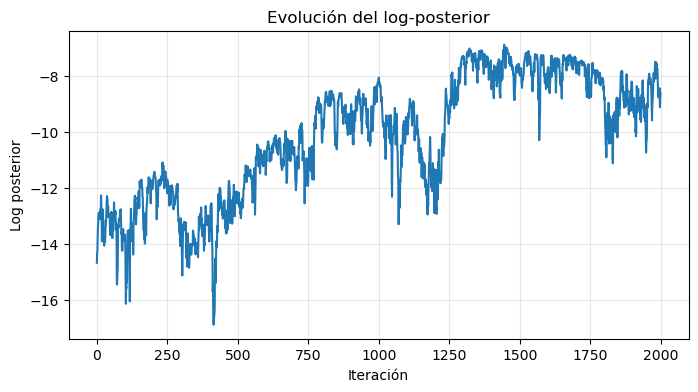

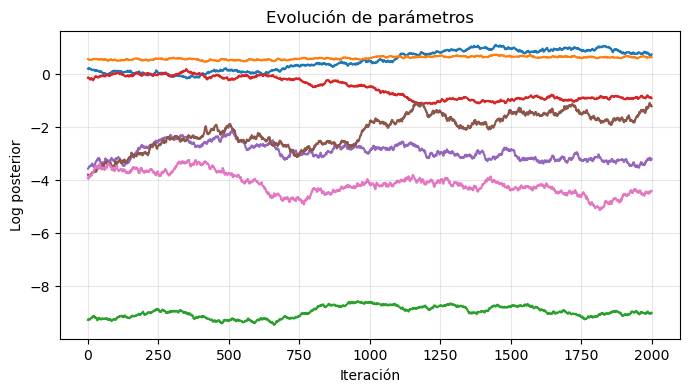

In [83]:
theta_samples = results["theta_samples"]
posterior = results["posterior_samples"]


A_mean = np.mean(theta_samples[:, :4], axis=0).reshape(2,2)
print("Matriz A promedio:")
print(A_mean)

plt.figure(figsize=(8,4))
plt.plot(posterior)
plt.title("Evolución del log-posterior")
plt.xlabel("Iteración")
plt.ylabel("Log posterior")
plt.grid(True, alpha=0.3)
plt.show()


plt.figure(figsize=(8,4))
plt.plot(theta_samples)
plt.title("Evolución de parámetros")
plt.xlabel("Iteración")
plt.ylabel("Log posterior")
plt.grid(True, alpha=0.3)
plt.show()

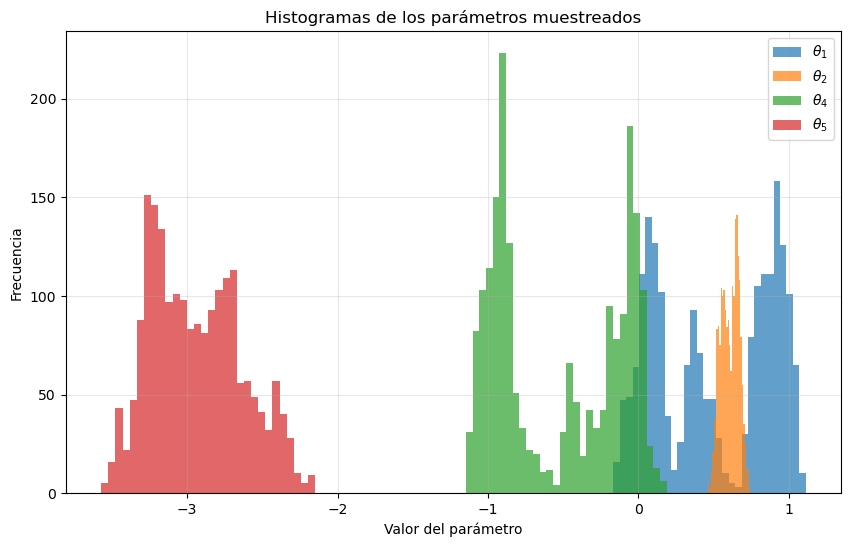

In [84]:
plt.figure(figsize=(10, 6))
plt.hist(theta_samples[:, 0], bins=30, alpha=0.7, label=r'$\theta_1$')
plt.hist(theta_samples[:, 1], bins=30, alpha=0.7, label=r'$\theta_2$')
#plt.hist(theta_samples[:, 2], bins=30, alpha=0.7, label=r'$\theta_3$')
plt.hist(theta_samples[:, 3], bins=30, alpha=0.7, label=r'$\theta_4$')
plt.hist(theta_samples[:, 4], bins=30, alpha=0.7, label=r'$\theta_5$')
#plt.hist(theta_samples[:, 5], bins=30, alpha=0.7, label =r'$\theta_6$')
#plt.hist(theta_samples[:, 6], bins=30, alpha=0.7, label =r'$\theta_7$')
plt.title("Histogramas de los parámetros muestreados")                  
plt.xlabel("Valor del parámetro")
plt.ylabel("Frecuencia")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()